# Permittivity Model

## Imports

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

## Data Gen

In [13]:
# Parameters
permittivities = np.linspace(10, 100, 10)  # 10 different permittivity values
input_amplitudes = np.arange(0.1, 1.2, 0.2)  # 0.1V to 1.0V in 0.2V steps (6 values)
frequencies = np.arange(1, 101, 20)  # 1Hz to 100Hz in 20Hz steps (5 values)

# Circuit parameters (fixed)
R = 100  # Series resistance (Ohms)
area = 0.01  # Electrode area (m^2) - fixed
distance = 0.001  # Electrode spacing (m) - fixed
epsilon_0 = 8.854e-12  # Permittivity of free space (F/m)

# Noise parameters
phase_noise_std = 0.5  # degrees
impedance_noise_std = 0.02  # 2% relative noise

def calculate_impedance(epsilon_r, freq, V_in):
    """
    Calculate impedance for a parallel plate capacitor with series resistance
    
    Capacitance: C = epsilon_0 * epsilon_r * A / d
    Impedance: Z = R - j*Xc where Xc = 1/(ω*C)
    """
    # Calculate capacitance from permittivity
    C = epsilon_0 * epsilon_r * area / distance
    
    # Angular frequency
    omega = 2 * np.pi * freq
    
    # Capacitive reactance
    Xc = 1 / (omega * C)
    
    # Impedance magnitude and phase
    Z_mag = np.sqrt(R**2 + Xc**2)
    phase_rad = -np.arctan(Xc / R)
    phase_deg = np.degrees(phase_rad)
    
    return Z_mag, phase_deg, C

# Generate dataset
data = []
print("Generating permittivity impedance data...")
print(f"Permittivities: {len(permittivities)}")
print(f"Input amplitudes: {len(input_amplitudes)}")
print(f"Frequencies: {len(frequencies)}")
print(f"Total samples: {len(permittivities) * len(input_amplitudes) * len(frequencies)}")

for epsilon_r in permittivities:
    for V_in in input_amplitudes:
        for freq in frequencies:
            # Calculate ideal values
            Z_mag, phase_deg, C = calculate_impedance(epsilon_r, freq, V_in)
            
            # Add measurement noise
            Z_mag_noisy = Z_mag * (1 + np.random.normal(0, impedance_noise_std))
            phase_deg_noisy = phase_deg + np.random.normal(0, phase_noise_std)
            
            data.append({
                'input_amplitude': V_in,
                'frequency': freq,
                'impedance_magnitude': Z_mag_noisy,
                'phase': phase_deg_noisy,
                'permittivity': epsilon_r,
                'capacitance': C  # Include for reference
            })

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('permittivity_data.csv', index=False)
print(f"\nGenerated {len(df)} samples")
print(f"Saved to 'permittivity_data.csv'")

# Display statistics
print("DATASET STATISTICS")
print(f"\nPermittivity range: {df['permittivity'].min():.1f} to {df['permittivity'].max():.1f}")
print(f"Input amplitude range: {df['input_amplitude'].min():.2f}V to {df['input_amplitude'].max():.2f}V")
print(f"Frequency range: {df['frequency'].min():.0f}Hz to {df['frequency'].max():.0f}Hz")
print(f"Impedance range: {df['impedance_magnitude'].min():.2f}Ω to {df['impedance_magnitude'].max():.2f}Ω")
print(f"Phase range: {df['phase'].min():.2f}° to {df['phase'].max():.2f}°")
print(f"Capacitance range: {df['capacitance'].min():.3e}F to {df['capacitance'].max():.3e}F")

print("\nFirst 10 rows:")
print(df.head(10))

print("\nData generation complete! Run the model training script next.")

Generating permittivity impedance data...
Permittivities: 10
Input amplitudes: 6
Frequencies: 5
Total samples: 300

Generated 300 samples
Saved to 'permittivity_data.csv'
DATASET STATISTICS

Permittivity range: 10.0 to 100.0
Input amplitude range: 0.10V to 1.10V
Frequency range: 1Hz to 81Hz
Impedance range: 213616.28Ω to 185023998.22Ω
Phase range: -91.15° to -88.06°
Capacitance range: 8.854e-10F to 8.854e-09F

First 10 rows:
   input_amplitude  frequency  impedance_magnitude      phase  permittivity  \
0              0.1          1         1.815406e+08 -90.069100          10.0   
1              0.1         21         8.670636e+06 -89.237816          10.0   
2              0.1         41         4.363733e+06 -90.115762          10.0   
3              0.1         61         3.039873e+06 -89.614338          10.0   
4              0.1         81         2.198359e+06 -89.726138          10.0   
5              0.3          1         1.780888e+08 -90.232833          10.0   
6              0.3

## ML

### Setup

In [14]:
# Set random seed for reproducibility
np.random.seed(42)

# Load data
print("Loading permittivity data from CSV")
df = pd.read_csv('permittivity_data.csv')

print("DATASET OVERVIEW")
print(f"Shape: {df.shape[0]} samples, {df.shape[1]} features")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nStatistics:")
print(df.describe())

Loading permittivity data from CSV
DATASET OVERVIEW
Shape: 300 samples, 6 features

First 5 rows:
   input_amplitude  frequency  impedance_magnitude      phase  permittivity  \
0              0.1          1         1.815406e+08 -90.069100          10.0   
1              0.1         21         8.670636e+06 -89.237816          10.0   
2              0.1         41         4.363733e+06 -90.115762          10.0   
3              0.1         61         3.039873e+06 -89.614338          10.0   
4              0.1         81         2.198359e+06 -89.726138          10.0   

    capacitance  
0  8.854000e-10  
1  8.854000e-10  
2  8.854000e-10  
3  8.854000e-10  
4  8.854000e-10  

Statistics:
       input_amplitude  frequency  impedance_magnitude       phase  \
count       300.000000  300.00000         3.000000e+02  300.000000   
mean          0.600000   41.00000         1.158682e+07  -90.000939   
std           0.342136   28.33153         2.962552e+07    0.482469   
min           0.100000    

### Features

In [15]:
# Prepare features and target
# Features: input_amplitude, frequency, impedance_magnitude, phase
X = df[['input_amplitude', 'frequency', 'impedance_magnitude', 'phase']].values
y = df['permittivity'].values

print(f"\nPermittivity range: {y.min():.2f} to {y.max():.2f}")
print(f"Input amplitude range: {X[:, 0].min():.2f}V to {X[:, 0].max():.2f}V")
print(f"Frequency range: {X[:, 1].min():.0f}Hz to {X[:, 1].max():.0f}Hz")
print(f"Impedance range: {X[:, 2].min():.2f}Ω to {X[:, 2].max():.2f}Ω")
print(f"Phase range: {X[:, 3].min():.2f}° to {X[:, 3].max():.2f}°")

# Split data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Feature engineering: Added physics-motivated features
# Circuit parameters
R = 100
area = 0.01
distance = 0.001
epsilon_0 = 8.854e-12

# Calculate derived features
omega_train = 2 * np.pi * X_train[:, 1]  # Angular frequency
omega_test = 2 * np.pi * X_test[:, 1]

phase_rad_train = np.deg2rad(X_train[:, 3])
phase_rad_test = np.deg2rad(X_test[:, 3])

# Capacitive reactance from phase: Xc = -R * tan(phase)
Xc_train = -R * np.tan(phase_rad_train)
Xc_test = -R * np.tan(phase_rad_test)

# Capacitance estimate: C = 1/(ω * Xc)
C_estimate_train = 1 / (omega_train * Xc_train)
C_estimate_test = 1 / (omega_test * Xc_test)

# Permittivity estimate: epsilon_r = C * d / (epsilon_0 * A)
epsilon_estimate_train = C_estimate_train * distance / (epsilon_0 * area)
epsilon_estimate_test = C_estimate_test * distance / (epsilon_0 * area)

# Add engineered features
X_train_eng = np.column_stack([
    X_train,                    # Original 4 features
    1/X_train[:, 1],            # 1/freq
    Xc_train,                   # Capacitive reactance
    omega_train * Xc_train,     # ω*Xc
    C_estimate_train,           # Capacitance estimate
    epsilon_estimate_train      # Direct permittivity estimate
])

X_test_eng = np.column_stack([
    X_test,
    1/X_test[:, 1],
    Xc_test,
    omega_test * Xc_test,
    C_estimate_test,
    epsilon_estimate_test
])

# Scale features for Ridge regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)


Permittivity range: 10.00 to 100.00
Input amplitude range: 0.10V to 1.10V
Frequency range: 1Hz to 81Hz
Impedance range: 213616.28Ω to 185023998.22Ω
Phase range: -91.15° to -88.06°

Training samples: 225
Testing samples: 75


### Define Models

In [16]:
# Define models
models = {
    'Random Forest (n=30)': RandomForestRegressor(
        n_estimators=30, max_depth=8, min_samples_split=3, random_state=42
    ),
    'Random Forest (n=50)': RandomForestRegressor(
        n_estimators=50, max_depth=10, min_samples_split=3, random_state=42
    ),
    'Random Forest (n=100)': RandomForestRegressor(
        n_estimators=100, max_depth=12, min_samples_split=2, random_state=42
    )#,
    #'Ridge Regression': Ridge(alpha=0.1)
}

results = {}

### Train Models

In [17]:
print("MODEL TRAINING & EVALUATION")

for name, model in models.items():
    # Use scaled data for Ridge, original for Random Forest
    if 'Forest' in name:
        X_tr, X_te = X_train_eng, X_test_eng
    else:
        X_tr, X_te = X_train_scaled, X_test_scaled
    
    # Train
    model.fit(X_tr, y_train)
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation (5-fold)
    cv_scores = cross_val_score(
        model, X_tr, y_train, cv=min(5, len(X_train)), 
        scoring='neg_mean_absolute_error'
    )
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'cv_mae': cv_mae,
        'cv_std': cv_std
    }
    
    print(f"\n{name}:")
    print(f"  Test MAE:  {mae:.3f}")
    print(f"  Test MAPE: {mape:.2f}%")
    print(f"  Test R^2:   {r2:.4f}")
    print(f"  CV MAE:    {cv_mae:.3f} ± {cv_std:.3f}")

MODEL TRAINING & EVALUATION

Random Forest (n=30):
  Test MAE:  3.247
  Test MAPE: 8.15%
  Test R^2:   0.9763
  CV MAE:    5.040 ± 1.386

Random Forest (n=50):
  Test MAE:  3.205
  Test MAPE: 8.04%
  Test R^2:   0.9769
  CV MAE:    4.893 ± 1.304

Random Forest (n=100):
  Test MAE:  3.094
  Test MAPE: 8.08%
  Test R^2:   0.9792
  CV MAE:    4.853 ± 1.154


### Best Model (One to be used)

In [18]:
# Select best model (highest R^2)
best_name = max(results.keys(), key=lambda k: results[k]['r2'])
best_model = results[best_name]['model']
best_pred = results[best_name]['predictions']

print(f"BEST MODEL: {best_name}")

BEST MODEL: Random Forest (n=100)


### Feature Importance

In [19]:
# Feature importance
if 'Forest' in best_name:
    feature_names = [
        'V_in', 'Freq', 'Z_mag', 'Phase',
        '1/Freq', 'Xc', 'ω*Xc', 'C_est', 'ε_est'
    ]
    importances = best_model.feature_importances_
    
    print("\nFeature Importance:")
    for feat, imp in sorted(zip(feature_names, importances), 
                           key=lambda x: x[1], reverse=True):
        print(f"  {feat:15s}: {imp:.4f}")


Feature Importance:
  Z_mag          : 0.7179
  1/Freq         : 0.1242
  Freq           : 0.0924
  ε_est          : 0.0162
  C_est          : 0.0158
  ω*Xc           : 0.0117
  Xc             : 0.0105
  Phase          : 0.0089
  V_in           : 0.0024


### Prediction Analysis

In [20]:
# Detailed prediction analysis
print("SAMPLE PREDICTIONS")
for i in range(min(5, len(y_test))):
    actual = y_test[i]
    predicted = best_pred[i]
    error_abs = abs(actual - predicted)
    error_pct = error_abs / actual * 100
    
    print(f"\nSample {i+1}:")
    print(f"  V_in:       {X_test[i, 0]:.2f}V")
    print(f"  Frequency:  {X_test[i, 1]:.0f}Hz")
    print(f"  Impedance:  {X_test[i, 2]:.2f}Ω")
    print(f"  Phase:      {X_test[i, 3]:.2f}°")
    print(f"  Actual ε_r: {actual:.2f}")
    print(f"  Predicted:  {predicted:.2f}")
    print(f"  Error:      {error_abs:.2f} ({error_pct:.2f}%)")

SAMPLE PREDICTIONS

Sample 1:
  V_in:       0.90V
  Frequency:  61Hz
  Impedance:  411982.80Ω
  Phase:      -90.06°
  Actual ε_r: 70.00
  Predicted:  65.70
  Error:      4.30 (6.14%)

Sample 2:
  V_in:       1.10V
  Frequency:  21Hz
  Impedance:  949826.91Ω
  Phase:      -90.60°
  Actual ε_r: 90.00
  Predicted:  82.10
  Error:      7.90 (8.78%)

Sample 3:
  V_in:       0.10V
  Frequency:  41Hz
  Impedance:  730405.31Ω
  Phase:      -89.93°
  Actual ε_r: 60.00
  Predicted:  61.00
  Error:      1.00 (1.67%)

Sample 4:
  V_in:       0.30V
  Frequency:  81Hz
  Impedance:  2178894.00Ω
  Phase:      -90.70°
  Actual ε_r: 10.00
  Predicted:  13.50
  Error:      3.50 (35.00%)

Sample 5:
  V_in:       0.90V
  Frequency:  61Hz
  Impedance:  372874.68Ω
  Phase:      -89.61°
  Actual ε_r: 80.00
  Predicted:  72.00
  Error:      8.00 (10.00%)


### Plotting and Visualisation

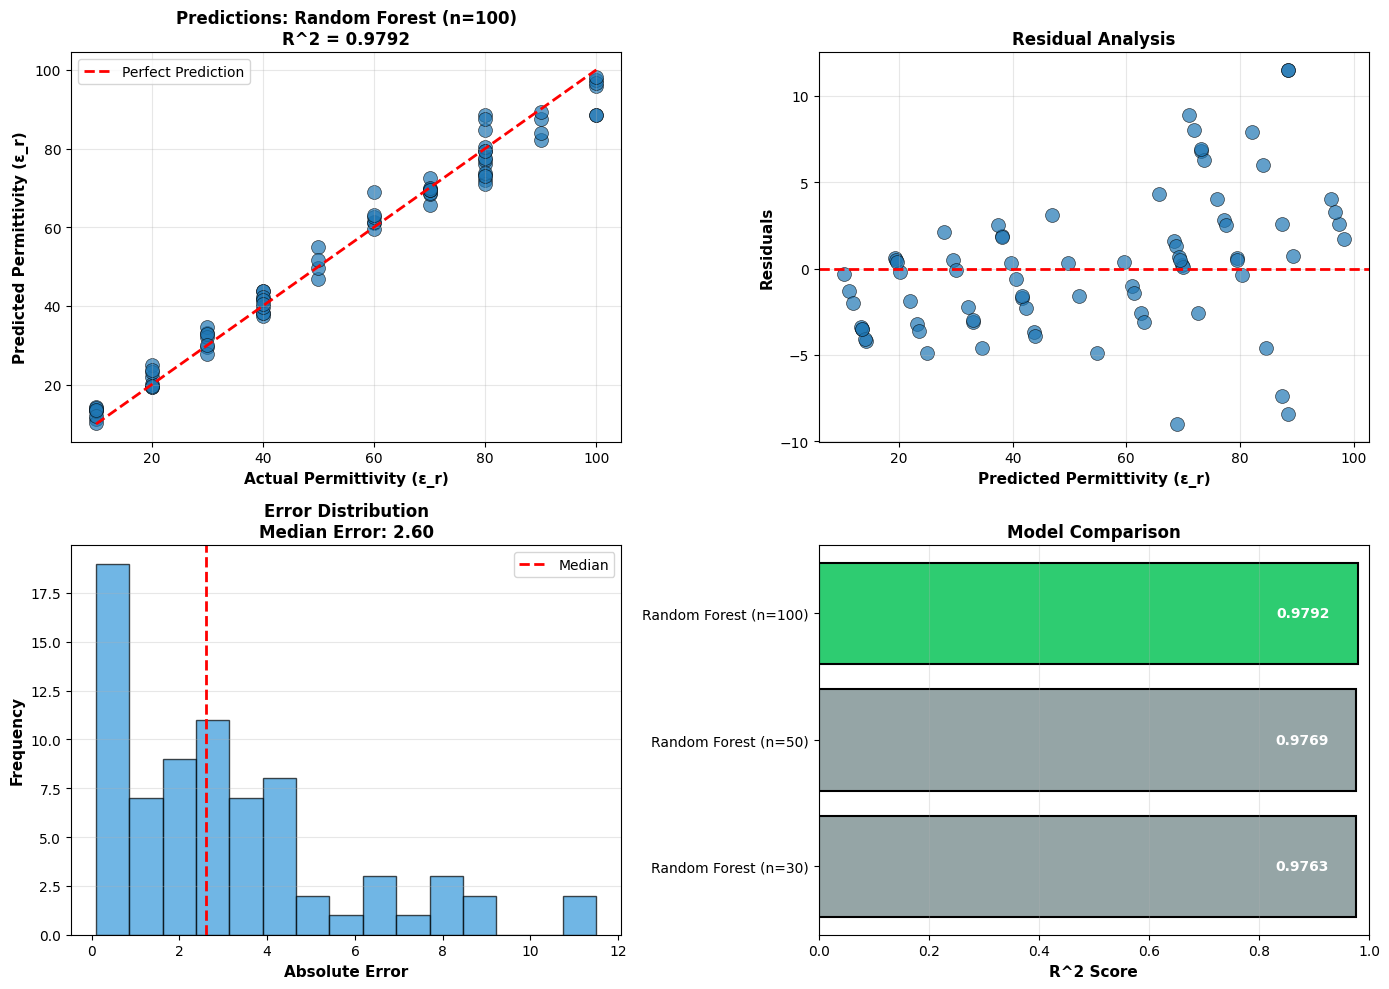

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predicted
ax = axes[0, 0]
ax.scatter(y_test, best_pred, alpha=0.7, s=100, edgecolors='black', linewidths=0.5)
min_val, max_val = y_test.min(), y_test.max()
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Permittivity (ε_r)', fontsize=11, fontweight='bold')
ax.set_ylabel('Predicted Permittivity (ε_r)', fontsize=11, fontweight='bold')
ax.set_title(f'Predictions: {best_name}\nR^2 = {results[best_name]["r2"]:.4f}', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Residuals
ax = axes[0, 1]
residuals = y_test - best_pred
ax.scatter(best_pred, residuals, alpha=0.7, s=100, edgecolors='black', linewidths=0.5)
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Predicted Permittivity (ε_r)', fontsize=11, fontweight='bold')
ax.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax.set_title('Residual Analysis', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Error distribution
ax = axes[1, 0]
errors_abs = np.abs(y_test - best_pred)
ax.hist(errors_abs, bins=15, edgecolor='black', alpha=0.7, color='#3498db')
ax.set_xlabel('Absolute Error', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title(f'Error Distribution\nMedian Error: {np.median(errors_abs):.2f}', 
             fontsize=12, fontweight='bold')
ax.axvline(np.median(errors_abs), color='r', linestyle='--', lw=2, label='Median')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Model comparison
ax = axes[1, 1]
model_names = list(results.keys())
r2_scores = [results[m]['r2'] for m in model_names]
colors = ['#2ecc71' if name == best_name else '#95a5a6' for name in model_names]
bars = ax.barh(model_names, r2_scores, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('R^2 Score', fontsize=11, fontweight='bold')
ax.set_title('Model Comparison', fontsize=12, fontweight='bold')
ax.set_xlim([0, 1])
ax.grid(True, alpha=0.3, axis='x')

# Add R^2 values on bars
for i, (bar, score) in enumerate(zip(bars, r2_scores)):
    ax.text(score - 0.05, i, f'{score:.4f}', 
            va='center', ha='right', fontweight='bold', color='white')

plt.tight_layout()
#plt.savefig('permittivity_model_results.png', dpi=150, bbox_inches='tight')
#print(f"\n Plots saved as 'permittivity_model_results.png'")
plt.show()

### Validation

In [23]:
print(f" R^2 score: {results[best_name]['r2']:.4f} (want > 0.90)")
print(f" MAPE: {results[best_name]['mape']:.2f}% (want < 10%)")
print(f" MAE: {results[best_name]['mae']:.3f}")
print(f" CV MAE similar to test MAE: {abs(results[best_name]['cv_mae'] - results[best_name]['mae'])/results[best_name]['mae']*100:.1f}% difference")


 R^2 score: 0.9792 (want > 0.90)
 MAPE: 8.08% (want < 10%)
 MAE: 3.094
 CV MAE similar to test MAE: 56.8% difference
